In [76]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [77]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [78]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [79]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [80]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [81]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [82]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [83]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [84]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"The most recent date in the data set is: {most_recent_date}")

The most recent date in the data set is: 2017-08-23


In [85]:
last_date = session.query(func.max(Measurement.date)).first()
last_date

('2017-08-23',)

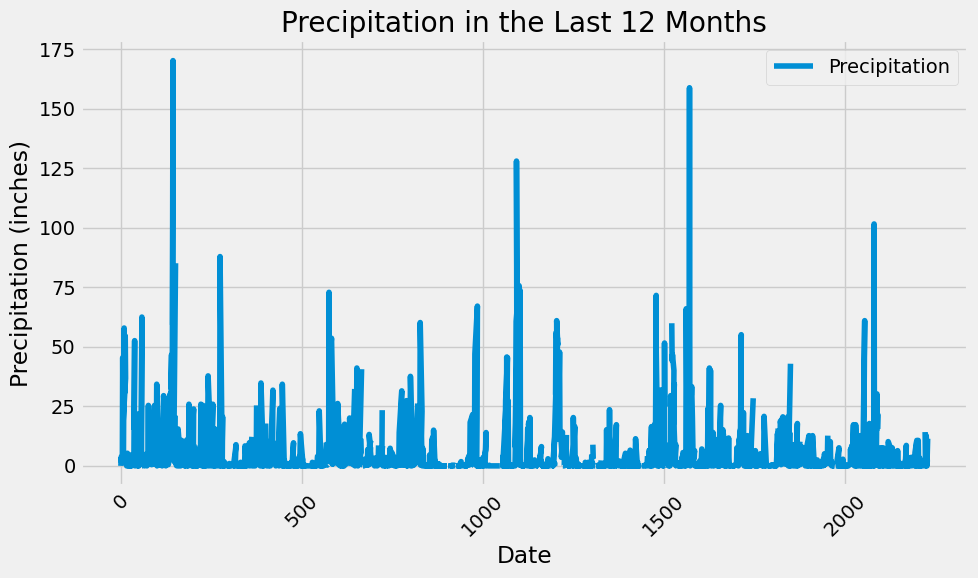

In [86]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
dt.date(2017,8,23) == session.query(func.max(Measurement.date)).first()
#last_date = dt.strptime(last_date, '%Y-%m-%d').date()
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
#df.set_index('Date', inplace=True)

# Sort the dataframe by date
df.sort_values('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(y='Precipitation', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation in the Last 12 Months')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [87]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df["Precipitation"].describe()
print(summary_stats)

count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [88]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [89]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

print("Most active stations:")
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")


Most active stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [90]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

lowest_temp = temp_stats[0][0]
highest_temp = temp_stats[0][1]
avg_temp = temp_stats[0][2]

print(f"Temperature statistics for the most active station (Station ID: {most_active_station}):")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")

Temperature statistics for the most active station (Station ID: USC00519281):
Lowest Temperature: 12.2
Highest Temperature: 29.4
Average Temperature: 22.03582251082252


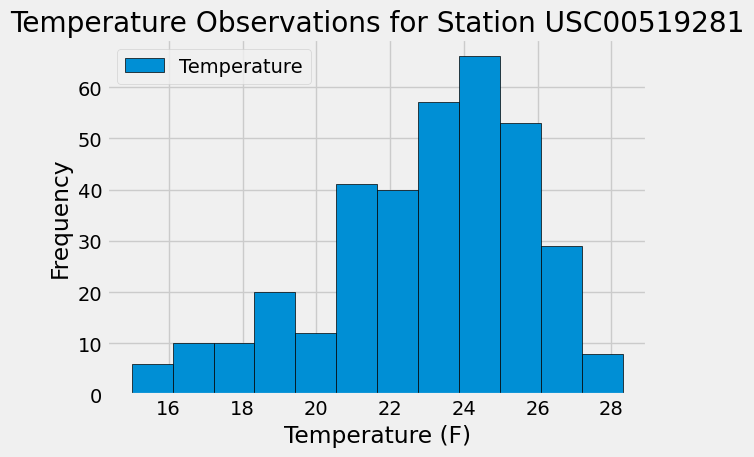

In [91]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

df = pd.DataFrame(results, columns=["Date", "Temperature"])

df.plot.hist(bins=12, edgecolor='black')
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observations for Station {most_active_station}")
plt.tight_layout()
plt.show()


# Close Session

In [92]:
# Close Session
session.close()